## Import dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
from scipy.fftpack import dct
import numpy as np
import tensorflow.keras as K
import tensorflow.keras.backend as Kback

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Dataloader

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/test_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 36411 images belonging to 7 classes.
Found 15601 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [3]:
print(train_dataset.class_indices)
print(validation_dataset.class_indices)
print(test_dataset.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Metrics

In [4]:
def f1_score(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

## Model

#### CBAM

In [5]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

#### Soft Attention

In [6]:
class SoftAttention(K.layers.Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = Kback.expand_dims(x,axis=-1)

        c3d = Kback.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = Kback.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = K.layers.Activation('relu')(conv3d)

        conv3d = Kback.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = Kback.squeeze(conv3d, axis=-1)
        conv3d = Kback.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = Kback.softmax(conv3d, axis=-1) 
        softmax_alpha = K.layers.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = Kback.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = Kback.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = Kback.expand_dims(x,axis=-2)
   
            u = K.layers.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = K.layers.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = Kback.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = Kback.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = Kback.expand_dims(exp_softmax_alpha, axis=-1)

            u = K.layers.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = K.layers.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

#### Deep Learner

In [7]:
input_layer = K.Input(shape=(160,160,3))
deep_learner = K.applications.DenseNet121(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in deep_learner.layers:
    layer.trainable = True
for i, layer in enumerate(deep_learner.layers):
    print(i, layer.name, "-", layer.trainable)

29084464/29084464 [==============================] - 0s 0us/step
0 input_1 - True
1 zero_padding2d - True
2 conv1/conv - True
3 conv1/bn - True
4 conv1/relu - True
5 zero_padding2d_1 - True
6 pool1 - True
7 conv2_block1_0_bn - True
8 conv2_block1_0_relu - True
9 conv2_block1_1_conv - True
10 conv2_block1_1_bn - True
11 conv2_block1_1_relu - True
12 conv2_block1_2_conv - True
13 conv2_block1_concat - True
14 conv2_block2_0_bn - True
15 conv2_block2_0_relu - True
16 conv2_block2_1_conv - True
17 conv2_block2_1_bn - True
18 conv2_block2_1_relu - True
19 conv2_block2_2_conv - True
20 conv2_block2_concat - True
21 conv2_block3_0_bn - True
22 conv2_block3_0_relu - True
23 conv2_block3_1_conv - True
24 conv2_block3_1_bn - True
25 conv2_block3_1_relu - True
26 conv2_block3_2_conv - True
27 conv2_block3_concat - True
28 conv2_block4_0_bn - True
29 conv2_block4_0_relu - True
30 conv2_block4_1_conv - True
31 conv2_block4_1_bn - True
32 conv2_block4_1_relu - True
33 conv2_block4_2_conv - True
34 c

#### Model

In [8]:
input_img = K.layers.Input(shape=(160,160,3)) 
feat_img = deep_learner(input_img)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(feat_img.shape[-1]),name='soft_attention')(feat_img)
attention_layer = K.layers.MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer)
conv = K.layers.MaxPooling2D(pool_size=(2, 2),padding="same")(feat_img)

conv = K.layers.concatenate([conv,attention_layer])
conv  = K.layers.Activation('relu')(conv)
flat = K.layers.GlobalAveragePooling2D()(conv)
output = K.layers.Dense(7, activation='softmax')(flat)

model = K.Model(inputs=input_img, outputs=output)
optimizer = K.optimizers.Adam(lr=0.01)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet121 (Functional)       (None, 5, 5, 1024)   7037504     ['input_2[0][0]']                
                                                                                                  
 soft_attention (SoftAttention)  [(None, 5, 5, 1024)  147472     ['densenet121[0][0]']            
                                , (None, 16, 5, 5)]                                               
                                                                                              

## Training

In [9]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='densenet121_SA.hdf5',
    monitor='val_f1_score',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
569/569 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.7511 - precision: 0.8167 - recall: 0.6836 - auc: 0.9616 - f1_score: 0.7403
Epoch 1: val_f1_score improved from -inf to 0.64248, saving model to densenet121_SA.hdf5
569/569 [==============================] - 510s 742ms/step - loss: 0.6729 - accuracy: 0.7511 - precision: 0.8167 - recall: 0.6836 - auc: 0.9616 - f1_score: 0.7403 - val_loss: 1.2064 - val_accuracy: 0.6441 - val_precision: 0.6845 - val_recall: 0.6062 - val_auc: 0.9112 - val_f1_score: 0.6425
Epoch 2/50
569/569 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8506 - precision: 0.8781 - recall: 0.8220 - auc: 0.9848 - f1_score: 0.8489
Epoch 2: val_f1_score did not improve from 0.64248
569/569 [==============================] - 265s 465ms/step - loss: 0.4095 - accuracy: 0.8506 - precision: 0.8781 - recall: 0.8220 - auc: 0.9848 - f1_score: 0.8489 - val_loss: 1.9047 - val_accuracy: 0.5269 - val_precision: 0.5570 - val_re

#### Training plots

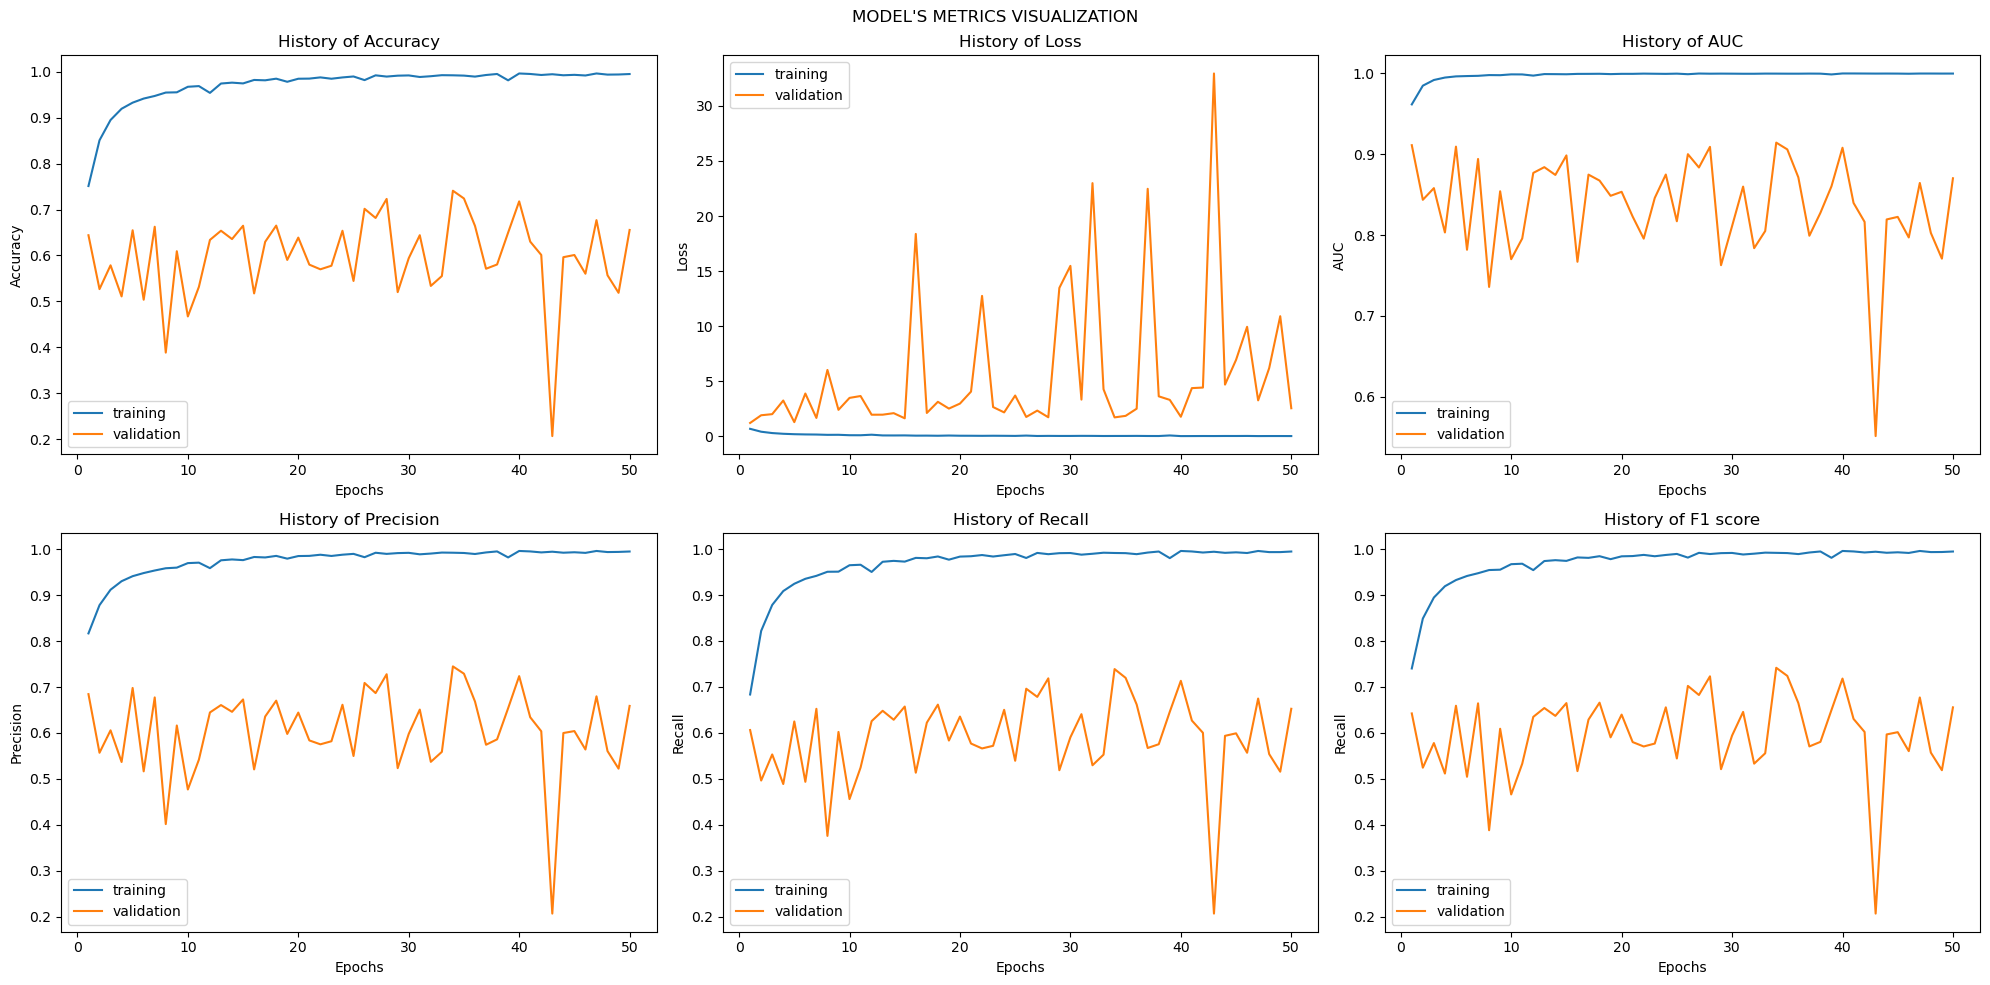

In [10]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    axes[1, 2].plot(range(1, len(f1_score) + 1), f1_score)
    axes[1, 2].plot(range(1, len(val_f1_score) + 1), val_f1_score)
    axes[1, 2].set_title('History of F1 score')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Recall')  # Corrected from 'Recall' to 'F1 score'
    axes[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['recall'], history.history['val_recall'],
               history.history['f1_score'], history.history['val_f1_score'])

## Testing

In [11]:
model.load_weights("/kaggle/working/densenet121_SA.hdf5")

# Evaluate the model
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Accuracy", accuracy)
print("Loss", loss)
print("Precision", precision)
print("Recall", recall)
print("AUC", auc)
print("F1-score", f1_score)

18/18 [==============================] - 21s 1s/step - loss: 0.7072 - accuracy: 0.8830 - precision: 0.8862 - recall: 0.8821 - auc: 0.9674 - f1_score: 0.8858
Accuracy 0.8830462098121643
Loss 0.7072086334228516
Precision 0.8861566781997681
Recall 0.8821396231651306
AUC 0.9673720598220825
F1-score 0.8857778310775757


/tmp/ipykernel_29/493592024.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


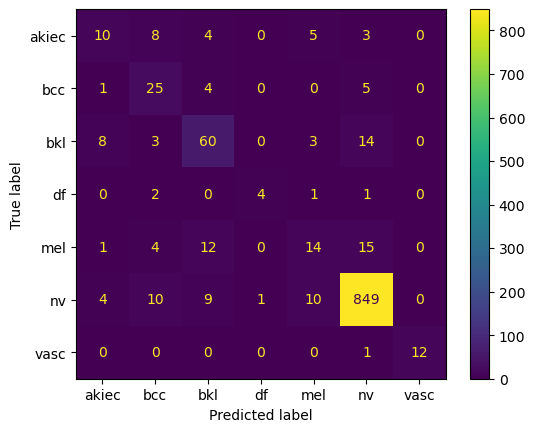

Classification Report
              precision    recall  f1-score   support

       akiec       0.42      0.33      0.37        30
         bcc       0.48      0.71      0.57        35
         bkl       0.67      0.68      0.68        88
          df       0.80      0.50      0.62         8
         mel       0.42      0.30      0.35        46
          nv       0.96      0.96      0.96       883
        vasc       1.00      0.92      0.96        13

    accuracy                           0.88      1103
   macro avg       0.68      0.63      0.64      1103
weighted avg       0.88      0.88      0.88      1103



In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))